In [1]:
%matplotlib inline
from collections import Counter
from math import pi

import numpy as np
import pandas as pd

from bokeh.io import output_notebook,show
from bokeh.palettes import Category20c, Accent
from bokeh.plotting import figure, show
from bokeh.transform import cumsum
from bokeh.models import ColumnDataSource,RangeTool
from bokeh.core.properties import value
from bokeh.layouts import column

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from TwitterCluster import TwitterCluster
from TwitterSentimentAnalyzer import TwitterSentimentAnalyzer

In [2]:
def get_clusters_result():
    """
    get clustering result of each tweet.
    return id-labels dataframe and representative words dataframe
    """
    # train or load kmeans cluster model 
    cluster = TwitterCluster()
    # the label of clusters that every tweets belongs to
    labels = cluster.get_labels()
    df = pd.read_csv('./data/Tweets.csv')
    df['label'] = labels.T
    labels = df.loc[:,['id','label']]
    # 5 words that are most representative words of each cluster
    representative = cluster.most_representative()
    return labels, representative

In [3]:
def get_senti_analyzer():
    """
    get the classifier of sentiment analysis
    """
    # load sentiment analyzer
    # if model exists, load from pickle file, otherwise train a new model and save it.
    analyzer = TwitterSentimentAnalyzer()
    return analyzer

In [4]:
def get_freq_dist(df, stop_words):
    freqdist = nltk.FreqDist()
    for i in df.index:
        tokens = df.loc[i, 'tokens']
        for token in tokens:
            token = token.lower()
            # skip numbers, @ string, word in stop words set
            if token.isdigit() or token in stop_words or token.startswith('@'):
                continue
            freqdist[token] += 1
    return freqdist

In [5]:
def get_stop_words():
    stop_words = set(stopwords.words('english')
                         + list(string.punctuation)
                         + ['..', '...', '“', '’', '”', '‘', '–'])
    return stop_words

In [6]:
def draw_clustering(data_label):
    data_label['angle'] = data_label['id']/data_label['id'].sum() * 2*pi
    data_label['color'] = Category20c[10]

    p_label = figure(plot_height=350, title="The cluster result of tweets",toolbar_location=None,
               tools="hover", tooltips="label @label: @id",x_range=(-0.5, 1.0))

    p_label.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend='label', source=data_label)

    p_label.axis.axis_label=None
    p_label.axis.visible=False
    p_label.grid.grid_line_color = None
    output_notebook()
    show(p_label)

In [7]:
def draw_distribution(data, name):
    data['angle'] = data['id']/data['id'].sum() * 2*pi
    data['color'] = ['#3182bd','#ff7f0e']

    p = figure(plot_height=350, title=name,toolbar_location=None,
               tools="hover", tooltips="@sentiment: @id",x_range=(-0.5, 1.0))

    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend='sentiment', source=data)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None
    output_notebook()
    show(p)

In [8]:
def draw_senti_clustering(df):
    cluster_result = list(df.index.map(str))
    attitudes = list(df.columns)
    colors = ['#1f77b4', '#ff7f0e']

    data = {'cluster_result' : cluster_result,
            'neg'   : list(df.neg),
            'pos'   : list(df.pos)}

    p = figure(x_range=cluster_result, plot_height=350, title="Sentiment analysis by cluster result",
               toolbar_location=None, tools="hover", tooltips=[("negative","@neg"),("positive","@pos")])

    p.vbar_stack(attitudes, x='cluster_result', width=0.9, color=colors, source=data,
                 legend=[value(x) for x in attitudes])

    p.y_range.start = 0
    p.x_range.range_padding = 0.2
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = "top_left"
    p.legend.orientation = "vertical"
    output_notebook()
    show(p)

In [9]:
def draw_time_seires(df):
    x_data = np.arange(df.shape[0])
    p = figure(plot_width=800, plot_height=400,x_axis_label='Time', y_axis_label='Sentiment')
    p.line(x_data, df['sentiment_change'], line_width=2)
    p.axis.axis_line_cap=None
    output_notebook()
    show(p)

In [10]:
def draw_word_cloud(df):
    tknzr = TweetTokenizer()
    df['tokens'] = df.apply(lambda row: tknzr.tokenize(row['text']), axis=1)
    stop_words = get_stop_words()
    freq = get_freq_dist(df,stop_words)
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(freq)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor('xkcd:salmon')
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")

In [11]:
# load origin data from csv file
df_comments=pd.read_csv('./data/Comments.csv',header=0)
df_tweets=pd.read_csv('./data/Tweets.csv',header=0)

In [12]:
# get clustering result and save it to csv file
labels, representative = get_clusters_result()
labels.to_csv('./result/cluster_result.csv',header=True,index=False)
representative.to_csv('./result/cluster_5_represent.csv',header=True,index=False)

In [13]:
# predict sentiment of tweets
analyzer = get_senti_analyzer()
df_comments_sa = analyzer.predict_df(df_comments)
df_tweets_sa = analyzer.predict_df(df_tweets)
df_comments_sa.to_csv('./result/comments_sa_result.csv',header=True,index=False)
df_tweets_sa.to_csv('./result/tweets_sa_result.csv',header=True,index=False)

In [14]:
# load sentiment analysis and clustering result from files
df_cluster=pd.read_csv('./result/cluster_result.csv',header=0) 
df_tweets_sa=pd.read_csv('./result/tweets_sa_result.csv',header=0)
df_comments_sa=pd.read_csv('./result/comments_sa_result.csv',header=0)

In [15]:
df=df_tweets_sa.merge(df_cluster)
data_label=df.groupby(['label']).count()
data_label

,id,sentiment
label,,
0,2,2
1,136,136
2,1093,1093
3,210,210
4,157,157
5,70,70
6,14,14
7,364,364
8,104,104


In [16]:
draw_clustering(data_label)

Loading BokehJS ...

In [17]:
data_comments = df_comments_sa.groupby('sentiment').count()
data_comments

,id
sentiment,
neg,16379
pos,28621


In [18]:
draw_distribution(data_comments,"Followers' attitudes")

Loading BokehJS ...

In [19]:
data_tweets = df_tweets_sa.groupby('sentiment').count()
data_tweets

,id
sentiment,
neg,1002
pos,1308


In [20]:
draw_distribution(data_tweets,'President Trump\'s attitude')

Loading BokehJS ...

In [21]:
data_sc = df.groupby(by = ['label','sentiment']).count().reset_index()
data_sc.columns = ['label','sentiment','count']
data_sc = data_sc.pivot(index='label',columns='sentiment',values='count').fillna(0).astype(np.int)
data_sc.columns = ['neg','pos']
data_sc = data_sc.reset_index().loc[:,['neg','pos']]

In [22]:
data_sc

,neg,pos
0,0,2
1,84,52
2,458,635
3,105,105
4,91,66
5,20,50
6,7,7
7,88,276
8,64,40
9,85,75


In [24]:
draw_senti_clustering(data_sc)

Loading BokehJS ...

In [25]:
#Find the tweets with the most comments
dt = df_comments['reply_id'].value_counts().head(3)
dt

1065743662464802817    3365
1064216956679716864    3364
1064540462848098304    2857
Name: reply_id, dtype: int64

In [26]:
#Sort above comments chronologically
ds = df_comments.loc[df_comments['reply_id']==1065743662464802817]
dm = ds.merge(df_comments_sa).sort_values(by="id")

#Add a new coloum to record the changing of sentiment
dm['sentiment_change']='0'

#Set neg=-1, pos=1
da = dm.replace('neg',-1)
db = da.replace('pos',1)

#Calculate the result by rows
db['sentiment_change']=db['sentiment'].cumsum()
db

,id,reply_id,text,user_id,tokens,sentiment,sentiment_change
2810,1065744654061039616,1065743662464802817,@realDonaldTrump Their job is to celebrate hol...,28352795,"[@realDonaldTrump, Their, job, is, to, celebra...",-1,-1
2809,1065744654367375366,1065743662464802817,@realDonaldTrump It's the Communists that want...,766148797,"[@realDonaldTrump, It's, the, Communists, that...",-1,-2
2808,1065744657152270336,1065743662464802817,@realDonaldTrump Is it 2020 yet?,18384246,"[@realDonaldTrump, Is, it, 2020, yet, ?]",-1,-3
2807,1065744657714278400,1065743662464802817,@realDonaldTrump You’re doing a fantastic job ...,3073381675,"[@realDonaldTrump, You, ’, re, doing, a, fanta...",1,-2
2806,1065744657827733506,1065743662464802817,@realDonaldTrump It is time to ignore the cour...,822527549871788032,"[@realDonaldTrump, It, is, time, to, ignore, t...",1,-1
2805,1065744662059720705,1065743662464802817,@realDonaldTrump Total BUNK! Fair immigration...,815903749021593601,"[@realDonaldTrump, Total, BUNK, !, Fair, immig...",1,0
2804,1065744662684565505,1065743662464802817,"@realDonaldTrump Cry,cry,https://t.co/pW5q12e1...",32863779,"[@realDonaldTrump, Cry, ,, cry, ,, https://t.c...",-1,-1
2803,1065744664223862784,1065743662464802817,@realDonaldTrump Take a day off the golf cours...,781960412161937408,"[@realDonaldTrump, Take, a, day, off, the, gol...",1,0
2802,1065744664752353280,1065743662464802817,@realDonaldTrump There are many circuits with ...,569005726,"[@realDonaldTrump, There, are, many, circuits,...",-1,-1
2801,1065744666610606082,1065743662464802817,@realDonaldTrump But...YOU never win a lawsuit???,560587423,"[@realDonaldTrump, But, ..., YOU, never, win, ...",1,0


In [27]:
draw_time_seires(db)

Loading BokehJS ...

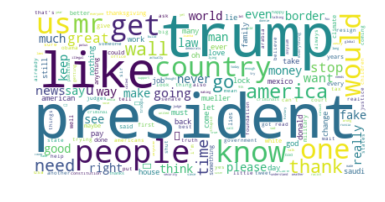

In [28]:
draw_word_cloud(df_comments)

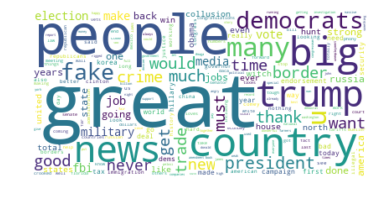

In [29]:
draw_word_cloud(df_tweets)